# Phase 3 Project submission

# Introduction
A pharmaceutical company wants to start manufacturing the seasonal flu vaccine as a new product line. They would like to know how they can increase vaccine uptake and optimize distribution strategies to ensure that they get to majority of the population. To get better insights the company would want to make data driven decisions.

## Objective
Launch and scale a seasonal flu vaccine product line successfully by increasing the uptake and optimizing distribution.

To get the insights we need, there are several questions we need to answer;
1. Identifying the populations that are less likely to be vaccinated.
2. Which factors drive vaccine acceptance or hesitancy.
3. Where they should prioritize distribution efforts geographically and demographically.


## Data Understanding
The data that will be used is the **H1N1 vaccine and seasonal flu vaccine** which was collected during The National 2009 H1N1 Flu Survey (NHFS).The target population for the NHFS was all persons 6 months or older living in the United States at the time of the interview. Data from the NHFS were used to produce timely estimates of vaccination coverage rates for both the monovalent pH1N1 and trivalent seasonal influenza vaccines. The NHFS was conducted between October 2009 and June 2010. It was one-time survey designed specifically to monitor vaccination during the 2009-2010 flu season in response to the 2009 H1N1 pandemic.

## Data Analysis
**1. Import the necessary libraries**

In [35]:
import pandas as pd  
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve
from sklearn.pipeline import Pipeline 
from sklearn.impute import SimpleImputer 
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree 

**2. Load the data**

In [2]:
features_df = pd.read_csv('training_set_features.csv')
labels_df = pd.read_csv('training_set_labels.csv')

# feature and target
X = features_df.drop(columns=['respondent_id'])
y = labels_df['seasonal_vaccine']

# display shape and preview of data
X.shape, y.shape, X.head(), y.value_counts()

((26707, 35),
 (26707,),
    h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
 0           1.0             0.0                        0.0   
 1           3.0             2.0                        0.0   
 2           1.0             1.0                        0.0   
 3           1.0             1.0                        0.0   
 4           2.0             1.0                        0.0   
 
    behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
 0                   0.0                   0.0                    0.0   
 1                   1.0                   0.0                    1.0   
 2                   1.0                   0.0                    0.0   
 3                   1.0                   0.0                    1.0   
 4                   1.0                   0.0                    1.0   
 
    behavioral_large_gatherings  behavioral_outside_home  \
 0                          0.0                      1.0   
 1                          0.0    

From the above we can see that there is a slight imbalance from the distribution of 14,272 for 0 (no vaccine) and 12,435 for 1 (received vaccine)

**3. Data preparation**

Handling the missing values: The missing data in the numerical columns was imputed with the **mean** and categorical columns with the **most frequent value**.

Feature scaling: The numerical features are standardized using **StandardScaler** in the preprocessing pipeline, 0,1.

Data balancing: This is important to avoid bias in regression and classification. Logistic regression is configured to use **balanced class weight** so that it assigns more importance to cases from minority class during training.  

In [3]:

# Identify columns by type
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = X.select_dtypes(include='object').columns.tolist()

# pipelines
numeric_pipeline = Pipeline([('imputer', SimpleImputer(strategy='mean')), ('scaler', StandardScaler())])
categorical_pipeline = Pipeline([('imputer', SimpleImputer(strategy='most_frequent')), ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer([('num', numeric_pipeline, numeric_cols), ('cat', categorical_pipeline, categorical_cols)])

X_preprocessed = preprocessor.fit_transform(X)
X_preprocessed.shape


(26707, 105)

After encoding and scaling, the data has 26,707 rows and 105 features. We can now train the model and do an evaluation using balanced logistic regression.

In [30]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# pipeline with preprocessing and balance logistic regression
model_pipeline = Pipeline([('preprocessor', preprocessor), ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))])

# fit the model
model_pipeline.fit(X_train, y_train)

# predict and evaluate
y_pred = model_pipeline.predict(X_test)
y_proba = model_pipeline.predict_proba(X_test)[:, 1]

report = classification_report(y_test, y_pred, output_dict=True)
roc_auc = roc_auc_score(y_test, y_proba)

print(classification_report(y_test, y_pred))
print(f"ROC AUC Score: {roc_auc:.3f}")

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2855
           1       0.77      0.77      0.77      2487

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342

ROC AUC Score: 0.854


From the above metrics we see that the ROC AUC score is 0.854 which is strong indicating that the model discriminates well between the vaccinated and non-vaccinated.

Let us do a visualization of the ROC curve plot which will indicate the predictive performance.

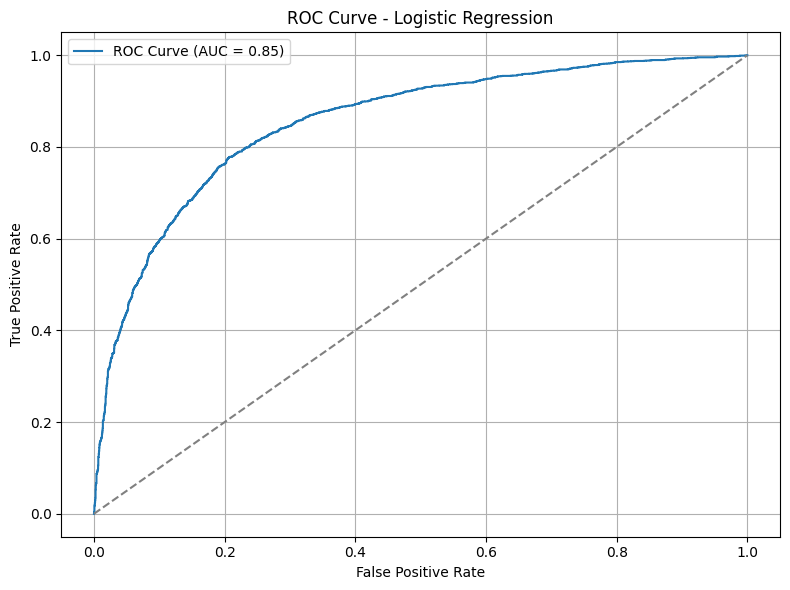

In [5]:
fpr, tpr, _ = roc_curve(y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Logistic Regression")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The AUC is approximately 0.85 which shows a strong predictive performance.

Hyperparameters are crucial for optimizing the performance of machine learning models. We will combine **Regularization Strength (C), Penalty type and Solver** and see which among them will tune our model best.

In [ ]:
# Hyperparameter grid
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],   
    'classifier__penalty': ['l1', 'l2'],                
    'classifier__solver': ['liblinear', 'saga'],         
    }


In [22]:
# Grid search with cross validation
grid_search = GridSearchCV(
    estimator=model_pipeline, 
    param_grid=param_grid,
    scoring='roc_auc',          
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),  
    n_jobs=-1,                   
    verbose=1                    
)
# Fit the grid search to training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 56 candidates, totalling 280 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer()),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['h1n1_concern',
                                                                          'h1n1_knowledge',
                                                                          'behavioral_antiviral_meds',
                                                                          'behavioral_avoidance',
                                                                          'behavioral_face_mask',
                                                                          'behavioral_was...
                                                                          'employment_industry',
                                                                          'employment_occupation'])])),
                                       ('classifier',
                                        LogisticRegression(class_weight='balanced',
                                                           max_iter=1000,
                                                           random_state=42))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'classifier__class_weight': ['balanced', None],
                         'classifier__penalty': ['l1', 'l2'],
                         'classifier__solver': ['liblinear', 'saga']},
             scoring='roc_auc', verbose=1)

In [29]:

best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

best_report = classification_report(y_test, y_pred, output_dict=True)
best_roc_auc = roc_auc_score(y_test, y_proba)

print(f"Best Hyperparameters: {best_params}")
print(f"ROC AUC: {roc_auc:.3f}")
print(classification_report(y_test, y_pred))

Best Hyperparameters: {'classifier__C': 1, 'classifier__class_weight': 'balanced', 'classifier__penalty': 'l1', 'classifier__solver': 'saga'}
ROC AUC: 0.854
              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2855
           1       0.77      0.77      0.77      2487

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



From the above we can see that the best hyperparameter was the **Regularization Strength**. However, the ROC AUC which we used for the scoring remained the same.



Training the model using decision tree

In [34]:
# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


# Define decision tree pipeline
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Train and predict
tree_pipeline.fit(X_train, y_train)
y_tree_pred = tree_pipeline.predict(X_val)
y_tree_proba = tree_pipeline.predict_proba(X_val)[:, 1]

# Evaluate
tree_report = classification_report(y_val, y_tree_pred, output_dict=True)
tree_auc = roc_auc_score(y_val, y_tree_proba)

print(classification_report(y_val, y_tree_pred))
print(f"Decision Tree ROC AUC: {tree_auc:.2f}")


              precision    recall  f1-score   support

           0       0.71      0.72      0.71      2855
           1       0.67      0.66      0.67      2487

    accuracy                           0.69      5342
   macro avg       0.69      0.69      0.69      5342
weighted avg       0.69      0.69      0.69      5342

Decision Tree ROC AUC: 0.69


From the above we get a ROC AUC of 0.69. Let us apply hyperparameters to tune this model and see if there will be a difference in our score of ROC AUC.





In [38]:

# Define hyperparameter grid for DecisionTreeClassifier
param_grid_tree = {
    'classifier__max_depth': [3, 5, 10, 20, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 5]
}

# Reuse tree pipeline
tree_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

# Set up GridSearchCV
grid_search_tree = GridSearchCV(tree_pipeline, param_grid_tree, scoring='roc_auc', cv=5)

# Fit on training data
grid_search_tree.fit(X_train, y_train)

# Evaluate best model
best_tree_model = grid_search_tree.best_estimator_
y_tree_pred_best = best_tree_model.predict(X_val)
y_tree_proba_best = best_tree_model.predict_proba(X_val)[:, 1]

# Compute performance metrics
tree_report_best = classification_report(y_val, y_tree_pred_best, output_dict=True)
tree_auc_best = roc_auc_score(y_val, y_tree_proba_best)

# Output best parameters and performance
print(grid_search_tree.best_params_)
print(f"Optimized Decision Tree ROC AUC: {tree_auc_best:.2f}")

{'classifier__max_depth': 5, 'classifier__min_samples_leaf': 5, 'classifier__min_samples_split': 2}
Optimized Decision Tree ROC AUC: 0.82


The ROC AUC score has improved from 0.69 to 0.82 which means our model has improved in performance.

The ROC AUC score from our first model using logistic regression is better as it was 0.85.

Let us fit the model to the test data and see how it performs. 

In [ ]:

# Load test set
X_test = pd.read_csv('test_set_features.csv')
respondent_ids = X_test['respondent_id']
X_test_cleaned = X_test.drop(columns=['respondent_id'])

# Final logistic regression model
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42))
])
# Fit the model 
final_model.fit(X, y)

# Predict on the training set
test_proba = final_model.predict_proba(X_test_cleaned)[:, 1]

# Create a submission DataFrame
submission_df = pd.DataFrame({
    'respondent_id': respondent_ids,
    'seasonal_vaccine': test_proba
})

# Show sample predictions
submission_df.head()


,respondent_id,seasonal_vaccine
0,26707,0.336681
1,26708,0.042487
2,26709,0.609328
3,26710,0.889048
4,26711,0.504725


In order to answer our questions above, let us see the most influential features in predicting the uptake of the seasonal flu vaccine using logistic regression.

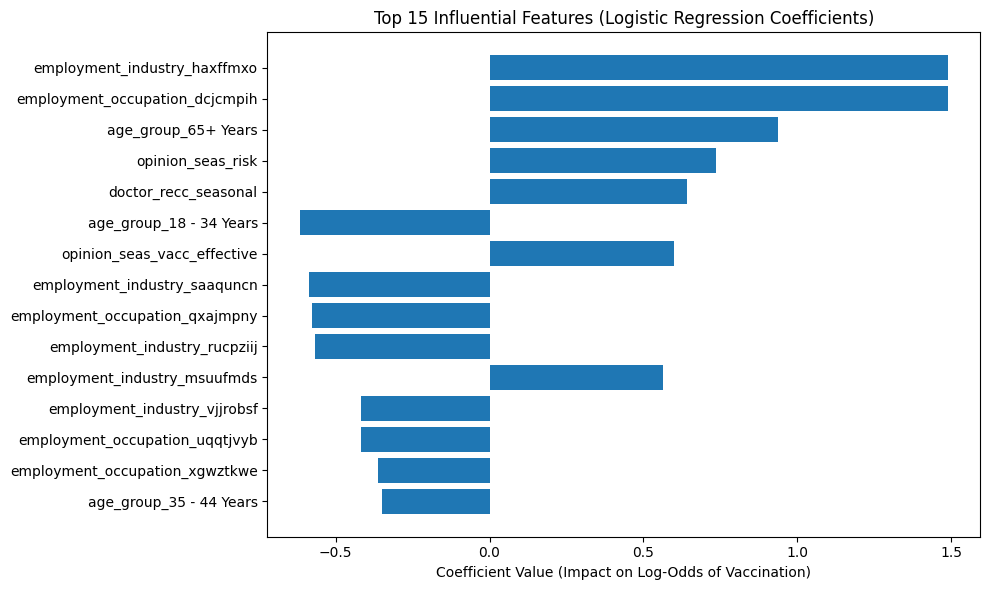

In [46]:

# Extract coefficients and feature names
log_reg_model = final_model.named_steps['classifier']
encoded_cat_features = final_model.named_steps['preprocessor'] \
    .transformers_[1][1] \
    .named_steps['encoder'] \
    .get_feature_names_out(categorical_cols)
all_features = numeric_cols + list(encoded_cat_features)
coefficients = log_reg_model.coef_[0]

# Create and plot top 15 influential features
coef_df = pd.DataFrame({'feature': all_features, 'coefficient': coefficients})
coef_df['abs_coef'] = np.abs(coef_df['coefficient'])
top_features = coef_df.sort_values(by='abs_coef', ascending=False).head(15)

plt.figure(figsize=(10, 6))
plt.barh(top_features['feature'], top_features['coefficient'])
plt.title("Top 15 Influential Features (Logistic Regression Coefficients)")
plt.xlabel("Coefficient Value (Impact on Log-Odds of Vaccination)")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


**Model Evaluation**

After modeling with the 2 algorithms, Logistic Regression performed best with a ROC AUC of 0.85 which identified strong predictors of the vaccine uptake. Logistic regression provides interpretable coefficients that quantify how features (e.g., age, doctor recommendation, perceived vaccine effectiveness) influence vaccination likelihood.

The ROC AUC score shows how well the model separates the two classes,that is the vaccinated vs non-vaccinated. 

The logistic regression model had a better precision - recall balance, that is it achieved higher F1 scores, precision and recall for those who got vaccinated.



## 4. Findings

1. After using Logistic Regression and Decision Tree algorithms to model our data, Logistic Regression performed best with a ROC AUC of 0.85 which identified strong predictors of the vaccine uptake.

2. The most influential factors that determine the uptake of the seasonal flu vaccine are:

    - doctor recommendation
    - Age group with 65+ years 
    - perceived vaccine effectiveness
    - the perceived risk 

3. The age group that is receptive to the seasonal flu vaccine is 45+ years with 65+ being the best at uptake of the vaccine.

4. The predictors that drive the seasonal flu vaccine hesitancy are:
    - Age group between 18-34 years
    - certain industries and occupations

## 5. Recommendations

1. Target on the high probability groups first, that is:
    - Adults aged 45+
    - Individuals with a positive view of vaccine effectiveness
    - Those with higher education levels
    - People with access to healthcare insurance

2. Doctor recommendation rated highly as one of the predictors of the vaccine uptake, therefore the company should build trust with the medical providers through outreach programs or trainings.

3. Partner with employers and insurers. There are certain industries and occupations that require seasonal flu vaccines for their staff given the nature of work environment they work in, therefore partnering with employers to offer vaccination programs should be considered. The company can offer health insurance companies discounts on their vaccine to push outreach.

4. The company should come up with an adaptive distribution strategy using predictive modeling to forecast the demand by regions and also demographics.
